<a href="https://colab.research.google.com/github/leobonn1/devai/blob/main/IAAM_Trabalho5_aprendizado_semi_supervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

# Resultado da Regressão Logística com dataset completo: score 0,91

---



In [42]:
from sklearn.linear_model import LogisticRegression

log_reg_completo = LogisticRegression(max_iter=10_000)
log_reg_completo.fit(X_train, y_train)
log_reg_completo.score(X_test, y_test)

0.906801007556675

# Resultado com 50 amostras aleatórias: score 0,78

In [165]:
import random
log_reg_50_aleatorios = LogisticRegression(max_iter=10_000)
random_indexes = random.sample(range(0, len(X_train) -1), 50)
X_train_aleatorios = X_train[random_indexes]
y_train_aleatorios = y_train[random_indexes]
log_reg_50_aleatorios.fit(X_train_aleatorios, y_train_aleatorios)
log_reg_50_aleatorios.score(X_test, y_test)

0.7279596977329975

# Usando algoritmo de clusterização GaussianMixture

In [44]:
from sklearn.cluster import KMeans

k = 50
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digits_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digits_idx]

In [146]:
from sklearn.mixture import GaussianMixture
from numpy import unique

k = 50
gaussian_model = GaussianMixture(n_components=k, n_init = 10, verbose =0, random_state = 42)
gaussian_model.fit(X_train)

scores = gaussian_model.score_samples(X_train)
gaussian_result = gaussian_model.predict(X_train)

representative_digits_idx = []
for i in range(k):
  idx = [index for index,value in enumerate(gaussian_result) if value == i]
  i_rep = idx[scores[idx].argmax()]
  representative_digits_idx.append(i_rep)

X_representative_digits = X_train[representative_digits_idx]



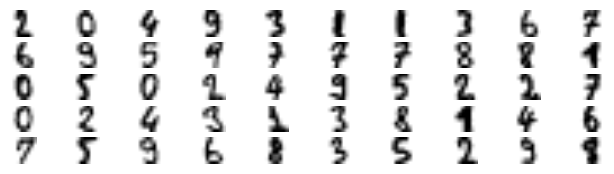

In [147]:
plt.figure(figsize=(8,2))
for index, X_representative_digit in enumerate(X_representative_digits):
  plt.subplot(k//10, 10, index+1)
  plt.imshow(X_representative_digit.reshape(8,8), cmap='binary', interpolation="bilinear")
  plt.axis("off")
plt.show()

In [152]:
import numpy as np

y_representative_digits = np.array([
    2, 0, 4, 9, 3, 1, 1, 3, 6, 7,
    6, 9, 5, 9, 7, 7, 7, 8, 8, 1,
    0, 5, 0, 2, 4, 9, 5, 2, 2, 7,
    0, 2, 4, 3, 1, 3, 8, 1, 4, 6,
    7, 5, 9, 6, 8, 3, 5, 2, 9, 8
])



# Usando y_representative_digits: score 0,866

In [153]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8664987405541562

# Usando y_train_propagated: score 0,889

In [156]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
  y_train_propagated[gaussian_result == i] = y_representative_digits[i]

In [155]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.889168765743073

# Usando y_train_partially_propagated:score 0,884

In [157]:
percentile_closest = 95

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]
print(len(y_train_partially_propagated))

1309


In [160]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8841309823677582

In [159]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.9679144385026738